In [44]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import pyspark
from pyspark.sql import SparkSession
import findspark
import sklearn.metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections
import os
from datetime import datetime
from tqdm import tqdm
import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer

# Finding Similar Documents

## 1.1 Set up the data

In [45]:
df = pd.read_csv(os.getcwd()+'/bank_transactions.csv')
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [46]:
df.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

We have some NaN values, we remove the index associated to them.

In [47]:
df = df.dropna()
df.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [48]:
df.dtypes

TransactionID               object
CustomerID                  object
CustomerDOB                 object
CustGender                  object
CustLocation                object
CustAccountBalance         float64
TransactionDate             object
TransactionTime              int64
TransactionAmount (INR)    float64
dtype: object

In [49]:
df.nunique()

TransactionID              1041614
CustomerID                  879358
CustomerDOB                  17233
CustGender                       3
CustLocation                  9275
CustAccountBalance          160723
TransactionDate                 55
TransactionTime              81855
TransactionAmount (INR)      92391
dtype: int64

We remove the id columns because they do not contain any relevant data about the customer.

In [50]:
df.drop(["TransactionID", "CustomerID"], axis=1, inplace=True)
df.head()

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [51]:
df['CustGender'].value_counts()

M    760978
F    280635
T         1
Name: CustGender, dtype: int64

We remove the index associated to the T gender because it appears only one time and we don't know its meaning.

In [52]:
df.drop(df[df['CustGender'].isin(['T'])].index,axis=0,inplace=True)
df['CustGender'].unique()

array(['F', 'M'], dtype=object)

Now, we want to process our data in order to do a MinHash in a good computing time.

In order to do so, we are going to remove some attributes and we are going to generate more general attributes so we don't have to much specific values to compare.

In [74]:
# This function associates to a datetime a part of the day (morning, afternoon, evening, night)
def periodOfDay(dt) :
    hour = int(dt.split(':')[0])
    if hour>=7 and hour<=12 :
        return 'morning'
    elif hour>=13 and hour<=18 :
        return 'afternoon'
    elif hour>=19 and hour<=22 :
        return 'evening'
    else :
        return 'night'
        
# This function takes a DataFrame in input and process its data so we can use it for MinHashing
def preprocessedData(df):

    # All the years of birth date are on two digits instead of 1800. This value doesn't make sense. 
    # So, we remove the index associated to this value.
    df.CustomerDOB = pd.to_datetime(df.CustomerDOB)
    df.drop(df[df.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)
    # Moreover, the dataset only provides the last two digits of the birth years. And, we have values up to 99. 
    # It means that we can then assume that all the years of birth are in the 1900s.
    # So, we process the datetime years that we got in the 2000s by removing 100 years to them.
    df.loc[df.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = df.loc[df.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

    df.CustGender = df['CustGender'].apply(lambda line: 'male' if line=='M' else 'female')
    
    # We get the age of each customer
    df['CustomerAge'] = (( pd.to_datetime('today') - df.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
    df['CustomerAge'] = df['CustomerAge'].astype(str)

    # We get the order of the balance of each customer because it will be time-expensive to compare exact values
    df['CustAccountBalance'] = df['CustAccountBalance'].apply(lambda balance: str(format(int(balance),'.1E')))
    df['CustAccountBalanceOrder'] = df['CustAccountBalance'].apply(lambda balance: balance.split('+')[-1])

    df['TransactionAmount (INR)'] = df['TransactionAmount (INR)'].apply(lambda line: str(int(line)))

    df['TransactionTime'] = df.TransactionTime.apply(lambda timestamp : datetime.utcfromtimestamp(int(timestamp)).strftime('%H:%M:%S'))

    # We get more general information about the transaction time so it's easier to compare it between users
    df['TransactionDayPeriod'] = df.TransactionTime.apply(periodOfDay)

    # We only keep those attributes because they give a good summary about the profile of each customer
    return df[['CustLocation', 'CustomerAge', 'CustAccountBalanceOrder', 'TransactionDayPeriod']]

For the MinHashing, we want to generate a boolean matrix (the characteristic matrix). This matrix is a representation of all the sets where the lines are the sets (one set per one customer) and the columns are all the possible values. So, if we have a 1 in column c and row r, we know that element for column c is a member of the set for row r.

In our case, a set is a concatenation of all the attributes of a customer after the preprocessing.

In [54]:
# This function get the shingles for all customers ie a concatenation of his attributes.
def getShingles(df) :
    shingles = []
    for i in (df.index) :
        shingles.append(' '.join(df.loc[i].values))
    return shingles

In [55]:
# This function computes a tf-idf matrix based on the shingle matrix
# So, if we have a non zero value in column c and row r, it means that element of column c is in the set of row r.
def getCharacteristicMatrix(shingles) :
    vectorizer = TfidfVectorizer() 
    characteristic_matrix = vectorizer.fit_transform(shingles)
    return characteristic_matrix

We get now generate the characteristic matrix for the MinHashing

In [ ]:
preprocessed_df = preprocessedData(df[:100000])
shingles = getShingles(preprocessed_df)
characteristic_matrix = getCharacteristicMatrix(shingles)

Here is a version of the dataset after having preprocessed the data.

In [82]:
preprocessed_df

,CustLocation,CustomerAge,CustAccountBalanceOrder,TransactionDayPeriod
0,JAMSHEDPUR,28.0,04,afternoon
1,JHAJJAR,66.0,03,afternoon
2,MUMBAI,26.0,04,afternoon
3,MUMBAI,49.0,05,afternoon
4,NAVI MUMBAI,35.0,03,night
...,...,...,...,...
100718,GURGAON,35.0,01,morning
100720,MUMBAI,46.0,04,night
100721,CHENNAI,30.0,04,morning
100722,MORADABAD,31.0,03,morning


We can notice that the characteristic_matrix is a sparse matrix. This will be helpful for computing time in MinHashing.

In [83]:
characteristic_matrix

<94038x2980 sparse matrix of type '<class 'numpy.float64'>'
	with 395508 stored elements in Compressed Sparse Row format>

We can see that the rows of this matrix represents the users and the columns the different values contained in the sets.

## 1.2 Fingerprint Hashing

In [159]:
# This class is used to generate the signature matrix based on the characteristic matrix
class MinHash :
    
    # n_permutations : number of permutations that we are going to apply on the characteristic matrix
    # n_shingles : number of different values contained in the sets of the shingles
    def __init__(self, n_permutations, n_shingles) :        
        self.n_permutations = n_permutations
        self.permutations = []
        self.signature_matrix = []
        # we generate random permutations if necessary
        for _ in range (n_permutations) :
            self.permutations.append(self.getPermutation(n_shingles))

    
    # input : characteristic matrix (size : n_customers x n_vocs)
    # output : signature matrix (size : n_permutations x n_customers)
    def __call__(self, characteristic_matrix) :
        n_customers = characteristic_matrix.shape[0]

        reduced_signature_matrix = []
        for i in tqdm(range(self.n_permutations)) :

            # we apply a permutation on the characteristic matrix
            permuted_matrix = self.permuteMatrix(self.permutations[i], characteristic_matrix)

            # we get the index of the first non-null element for each customer
            index = []
            for i in range(n_customers) :
                index.append(min(np.nonzero(permuted_matrix[i])[1]))
            reduced_signature_matrix.append(index)
        # we get the resulted signature_matrix
        reduced_signature_matrix = np.array(reduced_signature_matrix, dtype=int)

        if len(self.signature_matrix) == 0 :
            self.signature_matrix = reduced_signature_matrix
        else :
            self.signature_matrix = np.concatenate([self.signature_matrix,reduced_signature_matrix], axis=1)
            
        return reduced_signature_matrix

    
    # This function generates a random permutation by generating a random sample of all the values between 0 and n_shingles
    def getPermutation(self, n_shingles) :
        return np.random.permutation(range(0,n_shingles))
        

    # permutation : permutation to apply to the characteristic matrix
    # characteristic_matrix : size n_customers x n_vocs
    def permuteMatrix(self, permutation, characteristic_matrix) :

        # we get a copy of the characteristic matrix on which we are going to apply the permutation
        permuted_matrix = characteristic_matrix.copy()
        for i, j in enumerate(permutation) :
            permuted_matrix[:,j] = characteristic_matrix.getcol(i)
        
        return permuted_matrix

In [194]:

# Divide the signature matrix by band and put the customers into related bucket for each band
# signature matrix : size  n_permutations x n_customers
# b : number of bands
# r : number of rows in each band
class LSH :
    
    def __init__(self, b, r) :
        self.b = b
        self.r = r
        self.buckets = collections.defaultdict(set)
        
    # we split the signature matrix and we fill the buckets
    def __call__(self, signature_matrix) :
        bands = np.array_split(signature_matrix, self.b, axis=0)

        for _,band in enumerate(bands) :
            for c in range (signature_matrix.shape[1]) :
                self.buckets[tuple(band[:,c])].add(c)

    # This function is used to get all the similar customers for a query user
    def getSimilarities(self, signature_vector) :
        similar_customers = set()
        
        bands = np.array_split(signature_vector, self.b, axis=0)

        for i,band in enumerate(bands) :
            for c in range (signature_vector.shape[0]) :
                similar_customers = similar_customers.union(self.buckets[tuple(band)])
                
        return similar_customers   

To reduce the computing time, we divide our characteristic matrix into chunk. Then, we merge the signature matrix obtained.

In [87]:
n_permutations = 15 # The choice for this parameter is discussed later in the notebook
len_chunks = 10000

minHash = MinHash(n_permutations, characteristic_matrix.shape[1])

signature_matrix = np.array([], dtype=int)
if characteristic_matrix.shape[0] < len_chunks :
    # in this case we don't need to use chunks
    characteristic_matrix_reduced = scipy.sparse.lil_matrix(characteristic_matrix)
    minHash(characteristic_matrix_reduced)
else :
    for i in range ((characteristic_matrix.shape[0]//len_chunks)) :
        characteristic_matrix_reduced = scipy.sparse.lil_matrix(characteristic_matrix[i*len_chunks:(i+1)*len_chunks])
        minHash(characteristic_matrix_reduced)
    if characteristic_matrix.shape[0]%len_chunks != 0 :
        characteristic_matrix_reduced = scipy.sparse.lil_matrix(characteristic_matrix[(i+1)*len_chunks:])
        minHash(characteristic_matrix_reduced)

# Now, we have the signature matrix of all the characteristic matrix
signature_matrix = minHash.signature_matrix

100%|██████████| 15/15 [01:23<00:00,  5.56s/it]


The generation of the signature matrix takes so long because of the permutations of the characteristic matrix. So, we are going to work in a reduced dataset in order to be able to test it and to get conclusions.

In [88]:
signature_matrix.shape

(15, 94038)

### Threshold

We need to fix a value for the number of permutations that we want to compute.
This value is equal to b*r (b : number of bands and r : number of rows in each band).

And, we know that we can approximately link the threshold theta with r and b in this way $$\theta \approx (\frac{1}{b})^\frac{1}{r}$$ in order to be around the transition point to get the better compromise between false positives and false negatives.

So, we first need to fix theta. But we need to be careful because if we take a value too high of theta we increase the chance of getting false negatives (ie to don't output potential similar customers). And, if we take a theta too low we increase the chance of getting false positives (ie to output a lot of customers that are not similar). 

To find a good balance between false positives and flase negatives it is necessary to be closest of the transition point represented the approximation between theta, r and b.

In [89]:
theta = 0.6

Once theta is fixed, we get all the couples (b,r) that verify the approximation. We try to get the maximum value for b and r while having good computing times.

The values of b and r have also a huge impact on the false positives and false negatives. Indeed, if we decrease r, b increases and we get more false positives because when r is little we have less buckets because we have less keys. Moreover, if we increase r, b decreases and we get more false negatives because we increase the number of keys ie the number of buckets.

In [90]:
B = range(5,80)
R = range(2,20)
epsilon = 0.05

# We get all the couples (b,r) that can satisfy the approximation
couples = []
for b in B :
    for r in R :
        if (1/b)**(1/r) >= theta-epsilon and (1/b)**(1/r) <= theta+epsilon :
            couples.append((b,r))
couples

[(5, 3),
 (6, 3),
 (6, 4),
 (7, 4),
 (8, 4),
 (9, 4),
 (9, 5),
 (10, 4),
 (10, 5),
 (11, 5),
 (12, 5),
 (13, 5),
 (14, 5),
 (14, 6),
 (15, 5),
 (15, 6),
 (16, 5),
 (16, 6),
 (17, 5),
 (17, 6),
 (18, 5),
 (18, 6),
 (19, 5),
 (19, 6),
 (20, 6),
 (21, 6),
 (21, 7),
 (22, 6),
 (22, 7),
 (23, 6),
 (23, 7),
 (24, 6),
 (24, 7),
 (25, 6),
 (25, 7),
 (26, 6),
 (26, 7),
 (27, 6),
 (27, 7),
 (28, 6),
 (28, 7),
 (29, 6),
 (29, 7),
 (30, 6),
 (30, 7),
 (31, 6),
 (31, 7),
 (32, 6),
 (32, 7),
 (32, 8),
 (33, 6),
 (33, 7),
 (33, 8),
 (34, 6),
 (34, 7),
 (34, 8),
 (35, 6),
 (35, 7),
 (35, 8),
 (36, 6),
 (36, 7),
 (36, 8),
 (37, 7),
 (37, 8),
 (38, 7),
 (38, 8),
 (39, 7),
 (39, 8),
 (40, 7),
 (40, 8),
 (41, 7),
 (41, 8),
 (42, 7),
 (42, 8),
 (43, 7),
 (43, 8),
 (44, 7),
 (44, 8),
 (45, 7),
 (45, 8),
 (46, 7),
 (46, 8),
 (47, 7),
 (47, 8),
 (48, 7),
 (48, 8),
 (49, 7),
 (49, 8),
 (49, 9),
 (50, 7),
 (50, 8),
 (50, 9),
 (51, 7),
 (51, 8),
 (51, 9),
 (52, 7),
 (52, 8),
 (52, 9),
 (53, 7),
 (53, 8),
 (53, 9

We can take b=5 and r=3 in order to have a good computing time. But a better couple would be b=20 and r=6 so we have high values for both b and r and it is still computable.

## 1.3 Locality Sensitive Hashing

In [195]:
b = 5
r = 3
lsh = LSH(b, r)
lsh(signature_matrix)


In [119]:
lsh.buckets

defaultdict(set,
            {(93, 136, 439): {0,
              3697,
              4872,
              5320,
              6190,
              9593,
              11368,
              13276,
              14568,
              20441,
              22588,
              25788,
              26224,
              26906,
              27499,
              27927,
              29783,
              30757,
              31299,
              32356,
              33227,
              36517,
              37759,
              37898,
              38274,
              39109,
              40497,
              42948,
              47492,
              48260,
              48562,
              49159,
              49559,
              49668,
              49695,
              51880,
              52196,
              53388,
              54659,
              59153,
              59631,
              62583,
              63864,
              65417,
              65525,
              65775,
          

In [133]:
lsh.buckets[(957, 745, 1038)]

{2468, 10520, 36877, 87205, 89021}

We can have a little overview of the buckets. Let's pick two random customer in a random bucket. Let's say we pick two customers in bucket of key (957, 745, 1038).

In [93]:
preprocessed_df.iloc[2468]

CustLocation                KASHIPUR
CustomerAge                     27.0
CustAccountBalanceOrder           03
TransactionDayPeriod       afternoon
Name: 2638, dtype: object

In [97]:
preprocessed_df.iloc[36877]

CustLocation                KASHIPUR
CustomerAge                     27.0
CustAccountBalanceOrder           03
TransactionDayPeriod       afternoon
Name: 39589, dtype: object

In [96]:
preprocessed_df.iloc[87205]

CustLocation                KASHIPUR
CustomerAge                     40.0
CustAccountBalanceOrder           03
TransactionDayPeriod       afternoon
Name: 93429, dtype: object

In this bucket, we can see that some customers are identical with the preprocessed data that we generated earlier. And, we have some users that are almost identical but that have some difference in one field.

Now, let's get the similar customers for some queries.

In [154]:
query_df = pd.read_csv(os.getcwd()+'/query_users.csv')
query_df.head()

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,27/7/78,M,DELHI,94695.61,2/9/16,140310,65.0
1,6/11/92,M,PANCHKULA,7584.09,2/9/16,120214,6025.0
2,14/8/91,M,PATNA,7180.60,10/8/16,221732,541.5
3,3/1/87,M,CHENNAI,56847.75,29/8/16,144138,1000.0
4,4/1/95,M,GURGAON,84950.13,25/9/16,233309,80.0


In [155]:
# We preprocessed the data of the queries
preprocessed_query_df = preprocessedData(query_df)

# We get the associated characteristic matrix
shingles = getShingles(preprocessed_query_df)
characteristic_matrix = getCharacteristicMatrix(shingles)

In [167]:
# We get the signature_matrix
n_permutations = 15

minHashQuery = MinHash(n_permutations, characteristic_matrix.shape[1])

characteristic_matrix_reduced = scipy.sparse.lil_matrix(characteristic_matrix)
reduced_S_matrix = minHashQuery(characteristic_matrix_reduced)

# Now, we have the signature matrix of all the characteristic matrix of the queries
signature_matrix_query = minHashQuery.signature_matrix

100%|██████████| 15/15 [00:00<00:00, 21.30it/s]


In [203]:
# We get all the similar customers of each query customer
similar_customers = dict()
for i in range(preprocessed_query_df.shape[0]) :
    similar_customers[i] = lsh.getSimilarities(signature_matrix_query[:,i])

In [204]:
similar_customers

{0: set(),
 1: set(),
 2: set(),
 3: set(),
 4: set(),
 5: set(),
 6: set(),
 7: set(),
 8: set(),
 9: set(),
 10: set(),
 11: set(),
 12: set(),
 13: set(),
 14: set(),
 15: set(),
 16: set(),
 17: set(),
 18: set(),
 19: set(),
 20: set(),
 21: set(),
 22: set(),
 23: set(),
 24: set(),
 25: set(),
 26: set(),
 27: set(),
 28: set(),
 29: set(),
 30: set(),
 31: set(),
 32: set(),
 33: set(),
 34: set(),
 35: set(),
 36: set(),
 37: set(),
 38: set(),
 39: set(),
 40: set(),
 41: set(),
 42: set(),
 43: set(),
 44: set(),
 45: set()}

We get only empty sets because we constructed the signature matrix for the queries using a different characteristic matrix and using different permutations.

For the query users, we must construct the characteristic matrix using all the data of the customers. Otherwise, no key of the query users will match the keys of the customers.

So, we need to merge the query users data and the customers data to get one characteristic matrix and then we compute the signature matrix separately for both. And, we fill the buckets using for the customers in the bank_transactions dataset.

In [78]:
# Get the k most_similar customer of a query user

# Jaccard Similarity between two lists
# We will use it on the lists of customers attributes
def jaccard_similarity(list1, list2):
    intersection = set(list1).intersection(set(list2))
    union = set(list1+list2)
    return len(intersection) / len(union)

# This function gets the k most similar customers for a customer by using the jaccard similarity score on each potential customer
def getKMostSimilarCustomers(customerIndex, k) :
    similarCustomers = preprocessed_query_df.iloc[customerIndex].values
    customerData = preprocessed_query_df.iloc[customerIndex]
    jaccard_similarities = dict()
    for index in similarCustomers :
        similarCustomerData = preprocessed_df.iloc[index].values
        jaccard_similarities.append(jaccard_similarity(customerData, similarCustomerData))

    # we sort all the jaccard similarity scores and we only keep the k first ones

    return [(k,v) for k, v in sorted(jaccard_similarities.items(), key=lambda item: item[1])][:k]

# 2. Grouping customers together!

#### Data Cleaning

We need to pre_process our data to delete all the outliers, NA or mistakes and set the time variables in a right form.

In [110]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import pyspark
from pyspark.sql import SparkSession
import findspark
import sklearn.metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [269]:
bank_data = pd.read_csv("bank_transactions.csv")
bank_data.dropna(inplace=True)
bank_data.CustomerDOB = pd.to_datetime(bank_data.CustomerDOB)
bank_data.TransactionDate = pd.to_datetime(bank_data.TransactionDate)
bank_data.TransactionTime = bank_data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), "%H%M%S"))
bank_data = bank_data.rename(columns={'TransactionAmount (INR)':'TransactionAmount'})
bank_data["TransactionTime"] = bank_data["TransactionTime"].dt.hour

<AxesSubplot:>

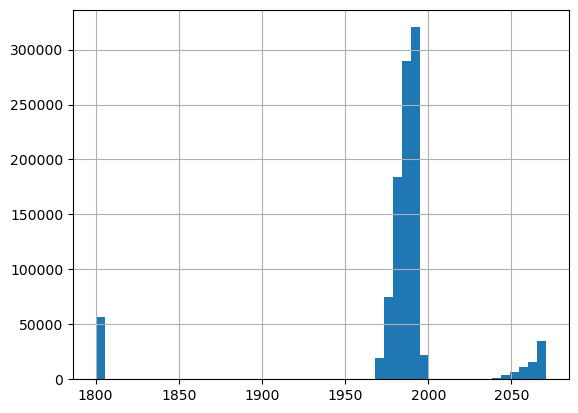

In [112]:
bank_data.CustomerDOB.dt.year.hist(bins=50)

Watching the histogram we can see that there are a lot of people born in 1800 and others in 2050 and after. The last range is a mistake for the millenium bug, so we can fix it by subtracting 100 years in each of this data.

In [270]:
bank_data.drop(bank_data[bank_data.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)
bank_data.loc[bank_data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = bank_data.loc[bank_data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

<AxesSubplot:>

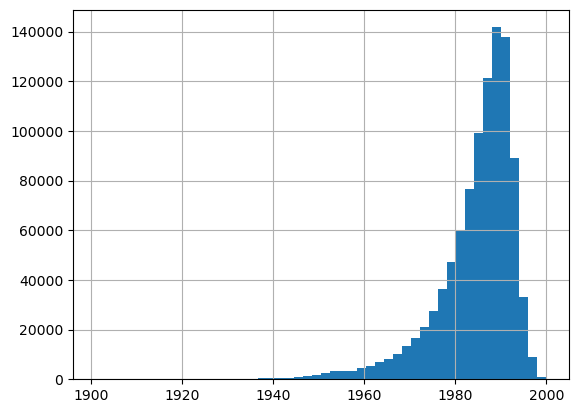

In [114]:
bank_data.CustomerDOB.dt.year.hist(bins=50)

Now the histogram shows right values of birthdays.

In [271]:
bank_data.to_pickle("bankdata")
data = pd.read_pickle("bankdata")

## 2.1 Getting your data + feature engineering

#### Define a new index
Now our purpose is to group by the transaction for each costumer and add new variables to create a dataset of 27 features.
Since we discovered that the CustomerID field is not a good approximation of the customer identity, a combination of fields is being used to identify the user. We will perform the operation of grouping by using newly defined columns which we believe may represent a single customer. In the following cells two strategies are explored, in the first one the location in which a single customer does the transaction is assumed to be not changing, in the second one the balance of a single customer is considered consant. The combination of one of these two fields, along with DOB and gender will be the new identification column.

In [272]:
#New columns
data["NewID1"] = data["CustomerDOB"].astype(str) + data["CustGender"] + data["CustLocation"]
data["NewID2"] = data["CustomerDOB"].astype(str) + data["CustGender"] + data["CustAccountBalance"].astype(str)

In [118]:
data[["CustomerID", "NewID1", "CustAccountBalance", "TransactionAmount"]].groupby(["NewID1"]).agg(lambda x: x.tolist())

,CustomerID,CustAccountBalance,TransactionAmount
NewID1,,,
1901-01-01MDELHI,[C4821377],[11378.03],[4.74]
1901-01-01MKANDIVALI WEST MUMBAI,"[C8513867, C7713887, C7813825, C7813828, C1413...","[222.44, 222.44, 222.44, 222.44, 222.44, 222.4...","[7554.0, 7105.0, 2177.5, 2640.0, 232.0, 1250.0..."
1901-01-01MPALI,[C6817759],[2368.32],[5790.0]
1901-01-05MMUMBAI,"[C1520561, C5920521, C2120581, C3620550]","[521.01, 521.01, 521.01, 521.01]","[650.0, 140.0, 210.0, 366.0]"
1901-01-07MGAUTAM BUDDH NAGAR,"[C5641445, C3941415]","[139.84, 139.84]","[600.0, 199.0]"
...,...,...,...
2000-12-01MSRINAGAR,"[C2110112, C6110173, C7310156]","[24900.78, 24900.78, 24900.78]","[100.0, 3044.0, 65.0]"
2000-12-09MNAVI MUMBAI,"[C5842760, C6442771, C3342730, C6442777, C1942...","[10446.17, 10446.17, 10446.17, 10446.17, 10446...","[620.0, 1114.31, 5668.0, 933.46, 230.0]"
2000-12-20MMUMBAI,"[C7920950, C1520914]","[8774.87, 8774.87]","[195.0, 4721.0]"


In [117]:
data[["CustomerID", "NewID2", "CustLocation", "TransactionAmount"]].groupby(["NewID2"]).agg(lambda x: x.tolist())

,CustomerID,CustLocation,TransactionAmount
NewID2,,,
1901-01-01M11378.03,[C4821377],[DELHI],[4.74]
1901-01-01M222.44,"[C8513867, C7713887, C7813825, C7813828, C1413...","[KANDIVALI WEST MUMBAI, KANDIVALI WEST MUMBAI,...","[7554.0, 7105.0, 2177.5, 2640.0, 232.0, 1250.0..."
1901-01-01M2368.32,[C6817759],[PALI],[5790.0]
1901-01-05M521.01,"[C1520561, C5920521, C2120581, C3620550]","[MUMBAI, MUMBAI, MUMBAI, MUMBAI]","[650.0, 140.0, 210.0, 366.0]"
1901-01-07M139.84,"[C5641445, C3941415]","[GAUTAM BUDDH NAGAR, GAUTAM BUDDH NAGAR]","[600.0, 199.0]"
...,...,...,...
2000-12-01M24900.78,"[C2110112, C6110173, C7310156]","[SRINAGAR, SRINAGAR, SRINAGAR]","[100.0, 3044.0, 65.0]"
2000-12-09M10446.17,"[C5842760, C6442771, C3342730, C6442777, C1942...","[NAVI MUMBAI, NAVI MUMBAI, NAVI MUMBAI, NAVI M...","[620.0, 1114.31, 5668.0, 933.46, 230.0]"
2000-12-20M8774.87,"[C7920950, C1520914]","[MUMBAI, MUMBAI]","[195.0, 4721.0]"


#### Observations
As we can see, we get a list of equal balances when we cosider the location constant and equal locations when considering the balance constant, also worth noting that the CustomerIDs are indeed different. Noting finally that the size of the two grouped by datasets is similar, we can conclude that these two operations yield similar results, corroborating the idea that these new definitions for the customer identity are more refined than CustomerID. One final note is that the majority of customers has multiple associated CustomerIDs. We now proceed to making the dataset, the new index will be the combination of DOB, gender and balance, as it yields slightly more rows.

In [277]:
data['Trans_over_100'] =  data.loc[data['TransactionAmount']>100,'TransactionAmount']
data['Small_transaction'] = data.loc[data['TransactionAmount']<100,'TransactionAmount']
data['Perc_transaction_balance'] = (data['TransactionAmount']/(data['CustAccountBalance']))*100
data['Big_balance'] = data.loc[data['CustAccountBalance']>100000,'CustAccountBalance']
data['Utilisation'] = data['CustAccountBalance']-data['TransactionAmount']
data['CustomerAge'] = ((pd.to_datetime('today') - data.CustomerDOB) / np.timedelta64(1,'Y')).astype(int)
data['Day_week'] = data.TransactionDate.dt.day_of_week
data['Month'] = data.TransactionDate.dt.month
data['Summer'] = data.loc[(data.TransactionDate.dt.month>=6) & (data.TransactionDate.dt.month<=9),'TransactionAmount']
data['Winter'] = data.loc[(data.TransactionDate.dt.month>=12) | (data.TransactionDate.dt.month<=2),'TransactionAmount']
data['Begin_month'] = data.loc[data.TransactionDate.dt.day<=15,'TransactionAmount']

In [283]:
dataframe={
           'Transactions_#':list(data.groupby("NewID2").TransactionID.count()), # Number of transactions
           'Ts_over_100':list(data.groupby("NewID2").Trans_over_100.count()), # Number of transactions over 100 units of currency
           'Small_transactions_#':list(data.groupby("NewID2").Small_transaction.count()), # Number of transactions under 100 units of currency
           'Ave_transaction':list(data.groupby("NewID2").TransactionAmount.mean()), # The average transaction
           'Min_transaction':list(data.groupby("NewID2").TransactionAmount.min()), # The minimum transaction
           'Max_transaction':list(data.groupby("NewID2").TransactionAmount.max()), # The maximum transaction
           'Balance':list(data.groupby("NewID2").CustAccountBalance.first()), # The average balance
           'Mean_%_Tr_balance':list(round((data.groupby("NewID2").Perc_transaction_balance.mean()),1)), # The percentage of the transactions on the balance
           'Average_util':list(data.groupby("NewID2").Utilisation.mean()), # The average utilisation
           'Gender':list(data.groupby("NewID2").CustGender.first()), # The gender most common
           'Location':list(data.groupby("NewID2").CustLocation.agg(lambda x: pd.Series.mode(x)[0])), # The location most common
           'Age':list(data.groupby("NewID2").CustomerAge.first().astype(int)), # The average of the ages
           'Big_balance':list(data.groupby("NewID2").Big_balance.count()), # A boolean for people under (0) or over (1) 100000 in balance
           'Day_week':list(data.groupby("NewID2").Day_week.agg(lambda x: pd.Series.mode(x)[0])), # The most common day of the week
           'Month':list(data.groupby("NewID2").Month.agg(lambda x: pd.Series.mode(x)[0])), # The most common month
           'Summer':list(data.groupby("NewID2").Summer.sum()), # The amount of transactions during summer
           'Winter':list(data.groupby("NewID2").Winter.sum()), # The amount of transactions during winter
           'Begin_month':list(data.groupby("NewID2").Begin_month.sum()), # The amount of transactions during the first half of all months
           "Accounts_#":list(data.groupby("NewID2").CustomerID.count()), # The number of accounts that have each customer
           "Total_expenses":list(data.groupby("NewID2").TransactionAmount.sum()), # The sum of all transactions of a customer
           "1st_quart_Tr":list(data.groupby("NewID2").TransactionAmount.quantile(0.25)), # First quartile of the transactions amount
           "3rd_quart_Tr":list(data.groupby("NewID2").TransactionAmount.quantile(0.75)), # Third quartile of the transactions amount
           "Median_Tr":list(data.groupby("NewID2").TransactionAmount.median()), # Median of the transactions amount
           "Hour":list(data.groupby("NewID2").TransactionTime.agg(lambda x: pd.Series.mode(x)[0])), # Most common hour of the day
           "Median_util":list(data.groupby("NewID2").Utilisation.median()), # Median of utilisation
           "1st_quart_util":list(data.groupby("NewID2").Utilisation.quantile(0.25)), # First quartile of utilisation
           "3rd_quart_util":list(data.groupby("NewID2").Utilisation.quantile(0.75)) # Third quartile of utilisation
           
          }

In [284]:
df=pd.DataFrame(dataframe)
df.to_pickle("2.1")

In [300]:
df = pd.read_pickle("2.1")

## 2.2 Choose your features (variables)!

In order to do the Principal Component Analysis we want to take only numerical variables and normalize them. This is done for a better comparison between variables that have completely different values or unit of measure.

In [304]:
features = ['Transactions_#','Ts_over_100','Small_transactions_#','Ave_transaction','Min_transaction','Max_transaction','Balance','Average_util','Age','Big_balance','Day_week','Month','Summer','Begin_month',"Accounts_#","Total_expenses","1st_quart_Tr","3rd_quart_Tr","Median_Tr","Median_util","1st_quart_util","3rd_quart_util"]

x = df.loc[:, features].values

# Standardizing and normalizing the features
x = StandardScaler().fit_transform(x)
z = normalize(x)
newdf=pd.DataFrame(z, columns=features)

Now that we have our dataset rescaled and normalized, we can use the method of the Principal Component Analysis.

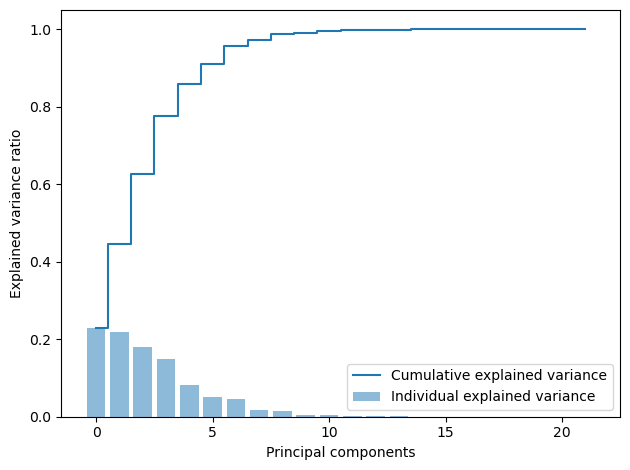

In [305]:
# Instantiate PCA
pca = PCA()
# Determine transformed features
z = pca.fit_transform(z)
# Determine explained variances and the cumulative sum
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
# Plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [306]:
len(cum_sum_eigenvalues[cum_sum_eigenvalues<0.70])+1

4

We can notice that the first 4 principal components explain more than 70% of variance so now we want to create a dataframe with only these 4 components.

In [307]:
pca1 = PCA(n_components=4)
PCA_f = pca1.fit_transform(newdf)
PCA_DF = pd.DataFrame(data = PCA_f, columns = ['pc1', 'pc2','pc3', 'pc4'])
PCA_DF.to_pickle("pcadf")

## 2.3 Clustering!

#### MapReduce in pySpark

In [308]:
df = pd.read_pickle("pcadf")

In [309]:
# Pyspark initialization
findspark.init()
spark = SparkSession.builder.master("local[4]").getOrCreate()

In [310]:
df = pd.read_pickle("pcadf")
values = df.values.tolist()
sdf = spark.createDataFrame(values,["pc1","pc2","pc3","pc4"])

In the following cell is presented the code for the kmeans algorithm

In [314]:
k = 5
rdd = sdf.rdd.map(list)
vectorized_rdd = rdd.map(lambda row: np.array(row))

def distance(x, y):
    distance = np.zeros(len(y))
    for i in range(len(y)):         
        distance[i] = np.linalg.norm(x-y[i])
    key = np.argmin(distance)
    return (key, x)

init_c = np.array(df.sample(k))

diff = 999
while diff > 0.01:  # threshold for shortening computation time
    d = vectorized_rdd.map(lambda row: distance(row,init_c))
    updated_c = d.groupByKey().mapValues(lambda row: sum(row)/len(row)).collect()
    
    K_new = {}                               #
    for i in updated_c:                      # 
        K_new[i[0]]=i[1]                     # this block of code exists to keep
    finalist = []                            # track of the index of each centroid
    for i in range(k):                       #
        finalist.append(np.array(K_new[i]))  #
    final_c = np.array(finalist)
    
    diff = np.linalg.norm(final_c-init_c)
    init_c = final_c
    print(diff)  # printing out the difference value to monitor the execution of the algorithm
    
print(init_c)

0.7881772832013271
0.25973991315893136
0.19214808407731243
0.13796356540994986
0.1275126646699794
0.15312308312298759
0.17944529209684135
0.1756249592069066
0.14154886104033457
0.10569371086188888
0.07854345729832705
0.0641667592748653
0.05950177051352733
0.06147252594119607
0.0715624060179546
0.1071354975226038
0.1882191203164741
0.2347810922771789
0.17388908951232596
0.08989271570855932
0.04368019213754975
0.02042393037548946
0.008903463774776155
[[-4.13872164e-01  3.36667485e-01 -3.75862412e-01 -5.16141093e-04]
 [ 6.86680284e-02 -3.36964894e-02  1.73461222e-01  5.96167776e-01]
 [ 7.13551500e-01  2.07320905e-01 -1.46258015e-01 -1.17159215e-01]
 [-2.27635535e-01  1.57317551e-01  6.14979601e-01 -2.69687771e-01]
 [-1.04888713e-01 -6.24457224e-01 -1.83771796e-01 -9.64579643e-02]]


#### Optimal clustering
We will use the methods of the elbow and the silhouette to find out what is the optimal number of clusters in terms of scoring function and overlap. In this section will be used the already implemented version of kmeans inside sklearn

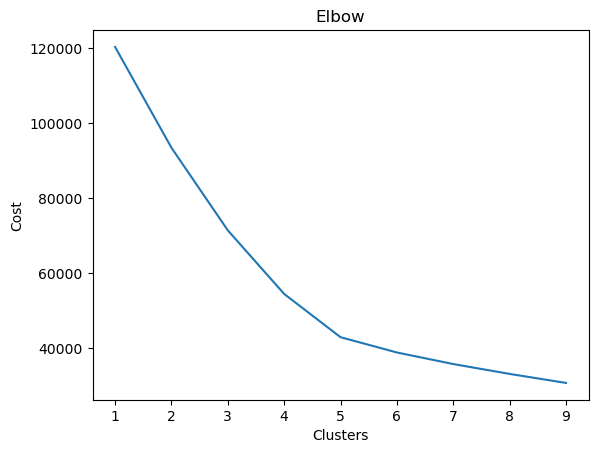

In [311]:
model = {}
for k in range(1,10):
    kmeans = KMeans(n_clusters=k).fit(df)
    model[k] = kmeans.inertia_
    
plt.figure()
plt.plot(list(model.keys()), list(model.values()))
plt.xlabel('Clusters')
plt.ylabel('Cost')
plt.title('Elbow')
plt.show()

The elbow method gives as optimal numbers of clusters a range between 4 and 6

Silhouette scores:

In [329]:
for i in range(2,10):
    labels = KMeans(n_clusters=i).fit(df).labels_
    print(str(i)+"=="+str(sklearn.metrics.silhouette_score(df,labels,sample_size=1000)))

2==0.5127119777381354
3==0.4790698734895891
4==0.5260777892125715
5==0.5718836782846851
6==0.5371146717212117
7==0.4566277424361988
8==0.39296592784872725
9==0.3378855206173493


#### Observations
As we can see from the values of the silhouette scores, the clusters could have a bit of overlap. Nevertheless we can conclude that in this case the optimal number of clusters will be 5 as it yields the highest silhouette score and it is in line with the results of the elbow method.

Comparing our kmeans algorithm with the version of kmeans++ implemented in the sklearn package, it can be seen that the resulting centroids are very similar vecors (the order is shuffled), this discrepancy is due to the threshold we opted to use in our version for time saving reasons. This last consideration points out the main difference between the sklearn version and ours, which is the running time, as the former is way faster.

In [317]:
kmeans = KMeans(n_clusters=5, init='k-means++').fit(df)
kmeans.cluster_centers_

array([[-0.4133628 ,  0.3371435 , -0.37620584, -0.00173938],
       [-0.22741427,  0.15753878,  0.61495363, -0.26987298],
       [-0.10402746, -0.62448444, -0.18435195, -0.09834787],
       [ 0.71345646,  0.20794369, -0.14505516, -0.11432898],
       [ 0.06395353, -0.03688398,  0.17278731,  0.59666038]])

In [316]:
final_c

array([[-4.13872164e-01,  3.36667485e-01, -3.75862412e-01,
        -5.16141093e-04],
       [ 6.86680284e-02, -3.36964894e-02,  1.73461222e-01,
         5.96167776e-01],
       [ 7.13551500e-01,  2.07320905e-01, -1.46258015e-01,
        -1.17159215e-01],
       [-2.27635535e-01,  1.57317551e-01,  6.14979601e-01,
        -2.69687771e-01],
       [-1.04888713e-01, -6.24457224e-01, -1.83771796e-01,
        -9.64579643e-02]])

## 2.4 Analysing your results!

We created a new column that shows the cluster to which each row belongs. Then we choose the average transaction, balance and total expences as more relevant variables relevant to identify the cluster of each customer. With the three functions below we want to divide in 4 classes each variable.

In [318]:
kmeans = KMeans(n_clusters=5, init='k-means++')
df["cluster"] = kmeans.fit_predict(df)

In [319]:
ogdf = pd.read_pickle("2.1")

In [320]:
def classTransactions(x):
    if x < 1000: return("0-1000")
    elif x <2500: return("1000-2500")
    elif x < 4000: return("2500-4000")
    else: return(">4000")
        
def classBalance(x):
    if x < 10000: return("0-10000")
    elif x <50000: return("10000-50000")
    elif x < 200000: return("50000-200000")
    else: return(">200000")
    
def classExpenses(x):
    if x < 1000: return("0-1000")
    elif x <5000: return("1000-5000")
    elif x < 20000: return("5000-20000")
    else: return(">20000")

In [321]:
ogdf["cluster"] = df["cluster"]
ogdf["Transactions_class"] = ogdf.Ave_transaction.apply(lambda row: classTransactions(row))
ogdf["Balance_class"] = ogdf.Balance.apply(lambda row: classBalance(row))
ogdf["Expenses_class"] = ogdf.Total_expenses.apply(lambda row: classExpenses(row))

Now that we have 3 new columns to show the class to which each row belongs, we want to create for each variable a pivot table normalized for rows.

In [248]:
pivot1 = round(pd.crosstab(index=ogdf.cluster, columns=ogdf.Transactions_class, values=ogdf.Ave_transaction, aggfunc="count", normalize="index")*100,1)
pivot2 = round(pd.crosstab(index=ogdf.cluster, columns=ogdf.Balance_class, values=ogdf.Balance, aggfunc="count", normalize="index")*100,1)
pivot3 = round(pd.crosstab(index=ogdf.cluster, columns=ogdf.Expenses_class, values=ogdf.Total_expenses, aggfunc="count", normalize="index")*100,1)

In [249]:
pivot1

Transactions_class,0-1000,1000-2500,2500-4000,>4000
cluster,,,,
0,33.9,28.5,11.4,26.2
1,60.6,27.2,6.0,6.1
2,62.4,25.1,6.3,6.2
3,69.1,22.5,5.0,3.5
4,64.9,24.2,5.9,4.9


In [250]:
pivot2

Balance_class,0-10000,10000-50000,50000-200000,>200000
cluster,,,,
0,25.4,29.8,22.2,22.6
1,35.9,35.5,18.5,10.2
2,48.9,33.8,12.2,5.1
3,51.0,32.6,12.5,4.0
4,50.0,31.6,13.3,5.1


In [251]:
pivot3

Expenses_class,0-1000,1000-5000,5000-20000,>20000
cluster,,,,
0,18.6,32.9,33.6,14.9
1,2.6,20.5,46.4,30.5
2,34.3,44.5,19.1,2.1
3,38.8,44.5,16.2,0.5
4,41.3,41.5,16.3,0.9


#### Observations
1. Transactions: Clusters from 1 to 4 have a similar trend regarding the average transaction amount, in particular we see that the majority of the transactions belong to the lower ranges, and cluster 3 has a more extreme behaviour with respect to the other three.

2. Balance: Also in this case the first cluster has a different trend from the others, having all four classes with similar percentages. In cluster 1 and even more in clusters 2, 3 and 4 the percentage about the lower class increases a lot, reaching values above 50%. Going through the other classes we can notice that clusters 2, 3 and 4 have a similar trend with low values for balances above 200000.

3. Expenses: In the case of the total expenses, we can see that clusters 3 and 4 have a very similar trend of percentages across the classes. Cluster 1 has peaks in the higher classes, having also a very low percentage of small expenses. Cluster 0 exhibits a more balanced trend across the classes, hinting to a gaussian distribution.

Summing up these observations we can conclude that Cluster 0 is composed by the wealthier people, Cluster 1 contains people more prone to spend money. Clusters 2, 3 and 4 are more representative of the behaviour of an average consumer, with Cluster 2 deviating a bit towards the behaviour of the upper clusters.

Silhouette score evaluation:

In [326]:
labels = KMeans(n_clusters=5).fit(df).labels_
print(str(sklearn.metrics.silhouette_score(df,labels)))

0.56703341333095


This silhouette score indicates a bit of overlap between the clusters, as expected after seeing the behaviours of the pivot tables and from the rough evaluation in point 2.3. The clustering performance in our opinion is overall acceptable.

# Command Line Question

This part allows us to make sure that we get the same results by using pandas or by using the command line.

In [3]:
full_df = pd.read_csv(os.getcwd()+'/bank_transactions.csv')
full_df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


For Command Line Question, we need to change the seperator of the file. Because the seperator is now a comma ',' and we also have commas in some values of the location attribute. So, we get some unexpected values when we use the command cut to get only some columns by separating with the delimiter ','. In order to avoid that, we generate a new csv file named bank_transactions_v2.csv which seperator is ';'.

In [4]:
full_df.to_csv(os.getcwd()+'/bank_transactions_v2.csv', sep=';', index=False)

In [5]:
from collections import Counter

print("Location which has the maximum number of purchases been made :", Counter(full_df.CustLocation).most_common(1))

Location which has the maximum number of purchases been made : [('MUMBAI', 103595)]


In [6]:
data = full_df[full_df.CustGender == 'F']
print("Amount spent by females :",sum(list(data['TransactionAmount (INR)'])))

Amount spent by females : 466810951.4299866


In [7]:
data = full_df[full_df.CustGender == 'M']
print("Amount spent by males :", sum(list(data['TransactionAmount (INR)'])))

Amount spent by males : 1181644838.11998


In [8]:
max_average_amount_transaction = 0

df_group_by_customer_id = full_df.groupby("CustomerID")

for c in tqdm(df_group_by_customer_id.indices.keys()) :
    customer_data = df_group_by_customer_id.get_group(c)
    amount_transactions_mean = customer_data["TransactionAmount (INR)"].mean()
    if amount_transactions_mean > max_average_amount_transaction :
        max_average_amount_transaction = amount_transactions_mean
        customer = c

print("Customer "+customer+" has the highest average transaction amount : "+str(max_average_amount_transaction))

100%|██████████| 884265/884265 [03:54<00:00, 3777.65it/s]

Customer C7319271 has the highest average transaction amount : 1560034.99


## Algorithmic Question

The idea behind this algorithm is to tranform the time interval between opening and closure $t$ of an entrance into a segment of length $t$, doing so the maximum number of superpositions between these segments for each unit of time will be the minimum number of guards required.

In [327]:
input_list = list(input().split())
M = list(map(int, input().split()))
doors = set(M)
array = np.array(M)

# transformation
D = {}
for i in doors:
    temp = np.where(array==i)[0]
    D[i] = set(range(min(temp),max(temp)+1))
    
# count of intersections
count = []
for i in range(len(array)):
    c=0
    for j in D.keys():
        if i in D[j]: c+=1
    count.append(c)

# output
if int(input_list[2])<max(count): print("NO")
else: print("YES")

6 10 3
1 2 3 1 4 4 3 1 5 3
YES
